In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ds = xr.open_dataset('../src/geopotential_500_test.nc')

In [3]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 24)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-01-01T23:00:00
Data variables:
    z          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-09-17 11:46:43 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

In [4]:
ds.z

<xarray.DataArray 'z' (time: 24, latitude: 721, longitude: 1440)>
[24917760 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-01-01T23:00:00
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

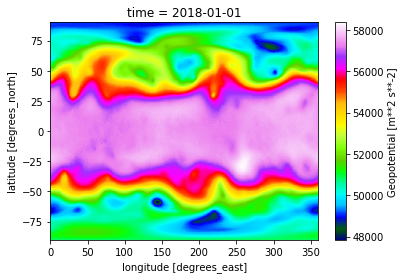

In [5]:
ds.z.isel(time=0).plot(cmap='gist_ncar');

## Define new grid

In [42]:
res = 180 / 32; res

5.625

In [84]:
res = 2.5

In [85]:
lat_out = np.arange(-90, 90+res, res)
lat_out

array([-90. , -87.5, -85. , -82.5, -80. , -77.5, -75. , -72.5, -70. ,
       -67.5, -65. , -62.5, -60. , -57.5, -55. , -52.5, -50. , -47.5,
       -45. , -42.5, -40. , -37.5, -35. , -32.5, -30. , -27.5, -25. ,
       -22.5, -20. , -17.5, -15. , -12.5, -10. ,  -7.5,  -5. ,  -2.5,
         0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ,
        22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,  42.5,
        45. ,  47.5,  50. ,  52.5,  55. ,  57.5,  60. ,  62.5,  65. ,
        67.5,  70. ,  72.5,  75. ,  77.5,  80. ,  82.5,  85. ,  87.5,
        90. ])

In [44]:
lon_out = np.arange(0, 360, res)
lon_out

array([  0.   ,   5.625,  11.25 ,  16.875,  22.5  ,  28.125,  33.75 ,
        39.375,  45.   ,  50.625,  56.25 ,  61.875,  67.5  ,  73.125,
        78.75 ,  84.375,  90.   ,  95.625, 101.25 , 106.875, 112.5  ,
       118.125, 123.75 , 129.375, 135.   , 140.625, 146.25 , 151.875,
       157.5  , 163.125, 168.75 , 174.375, 180.   , 185.625, 191.25 ,
       196.875, 202.5  , 208.125, 213.75 , 219.375, 225.   , 230.625,
       236.25 , 241.875, 247.5  , 253.125, 258.75 , 264.375, 270.   ,
       275.625, 281.25 , 286.875, 292.5  , 298.125, 303.75 , 309.375,
       315.   , 320.625, 326.25 , 331.875, 337.5  , 343.125, 348.75 ,
       354.375])

In [45]:
lat_out.shape, lon_out.shape

((33,), (64,))

In [46]:
grid_out = xr.Dataset(
    {
        'lat': (['lat'], lat_out),
        'lon': (['lon'], lon_out),
    }
)
grid_out

<xarray.Dataset>
Dimensions:  (lat: 33, lon: 64)
Coordinates:
  * lat      (lat) float64 -90.0 -84.38 -78.75 -73.12 ... 73.12 78.75 84.38 90.0
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    *empty*

## Set up regridder

In [47]:
import xesmf as xe

In [31]:
# Have to rename to lat/lon
ds = ds.rename({'latitude': 'lat', 'longitude': 'lon'})

ValueError: cannot rename 'latitude' because it is not a variable or dimension in this dataset

In [48]:
ds

<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1440, time: 24)
Coordinates:
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.25 359.5 359.75
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-01-01T23:00:00
Data variables:
    z        (time, lat, lon) float32 49096.93 49096.93 ... 50792.906 50792.906
Attributes:
    Conventions:  CF-1.6
    history:      2019-09-17 11:46:43 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

In [49]:
regridder = xe.Regridder(ds, grid_out, 'bilinear', periodic=True)

Overwrite existing file: bilinear_721x1440_33x64_peri.nc 
 You can set reuse_weights=True to save computing time.


In [50]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_721x1440_33x64_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (721, 1440) 
Output grid shape:          (33, 64) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True

In [51]:
ds_out = regridder(ds)

using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.


In [52]:
ds_out

<xarray.Dataset>
Dimensions:  (lat: 33, lon: 64, time: 24)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-01-01T23:00:00
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -90.0 -84.38 -78.75 -73.12 ... 73.12 78.75 84.38 90.0
Data variables:
    z        (time, lat, lon) float64 5.087e+04 5.087e+04 ... 4.89e+04 4.89e+04
Attributes:
    regrid_method:  bilinear

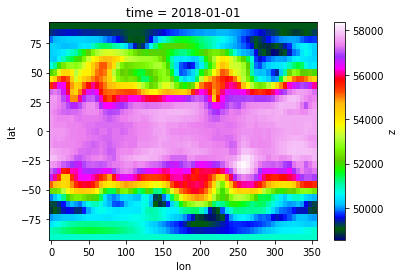

In [53]:
ds_out.z.isel(time=0).plot(cmap='gist_ncar')

In [54]:
ds_out.to_netcdf('./test_6deg.nc')

In [56]:
!ls -lh ./test_6deg.nc

-rw-r--r--  1 stephanrasp  staff   405K Sep 17 13:55 ./test_6deg.nc


In [57]:
0.4 * 365 /1000, 0.4 * 365 /1000 * 40

(0.146, 5.84)

In [23]:
1979-2016

-37

In [58]:
ds = xr.open_dataset('../src/single_test.nc')

In [59]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 2)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1980-01-01 2010-01-01
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    lsm        (time, latitude, longitude) float32 ...
    z          (time, latitude, longitude) float32 ...
    slt        (time, latitude, longitude) float32 ...
    tisr       (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-09-17 12:03:16 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

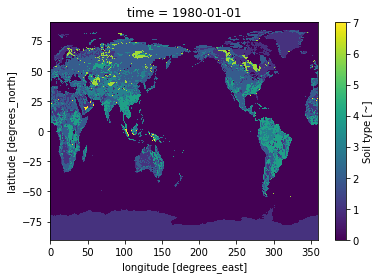

In [71]:
ds.slt.isel(time=0).plot()

In [73]:
60*693 / 1000

41.58

In [76]:
1/5.625**2 * 1000

31.60493827160494

In [77]:
5.8*60

348.0

In [79]:
2.5**2 / 2**2

1.5625

In [80]:
3/1.5

2.0

In [82]:
2*365/1000 * 40

29.2

In [83]:
30*60

1800